# **PROJECT TITLE :"Sentiment Analysis on Twitter Data"**  
---

**Author:** Priyanka Lakra  


# **1. PROJECT OVERVIEW**
---
- Objective: Classify tweets into Positive, Negative, or Neutral  
- Business Use: Understand customer sentiment for better decision-making  

# **2. BUSINESS PROBLEM**
---
Social media generates huge unstructured text. Companies struggle to identify whether the sentiment towards their brand/product is positive, negative, or neutral.  


# **3. IMPORT REQUIRED LIBRARIES**
---

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import spacy
import warnings
warnings.filterwarnings("ignore")


# **4. DATASET LOAD AND INSPECT**
---
- Source: [Kaggle – Twitter Entity Sentiment Analysis](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis)  
- Size: 110k+ tweets  
- Columns: `id`, `entity`, `sentiment`, `content`  

In [29]:
columns = ["id", "entity", "sentiment", "content"]

In [30]:
data = pd.read_csv("twitter_training.csv", names=columns, header=None)
data.head()

,id,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [31]:
df=data.copy()
df.head()

,id,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [32]:
print(df.shape)    

(74682, 4)


In [33]:
print(df.columns)   

Index(['id', 'entity', 'sentiment', 'content'], dtype='object')


# **5. DATA CLEANING**
---
- Add column names  
- Handle missing values and duplicates  

In [34]:
print(df.isnull().sum())

id             0
entity         0
sentiment      0
content      686
dtype: int64


In [35]:
df = df.dropna(subset=["content"])

In [36]:
print(df.isnull().sum())

id           0
entity       0
sentiment    0
content      0
dtype: int64


In [37]:
df.duplicated().sum()

np.int64(2341)

In [38]:
df = df.drop_duplicates()

In [39]:
df.duplicated().sum()

np.int64(0)

In [40]:
df.shape

(71655, 4)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71655 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         71655 non-null  int64 
 1   entity     71655 non-null  object
 2   sentiment  71655 non-null  object
 3   content    71655 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB


# **6. EXPLORATORY DATA ANALYSIS (EDA)**
---
- Sentiment distribution (positive, negative, neutral)  
- Most common entities in tweets  
- Word frequency and word clouds for each sentiment 

In [42]:
print(df['sentiment'].value_counts()) 


sentiment
Negative      21698
Positive      19713
Neutral       17707
Irrelevant    12537
Name: count, dtype: int64


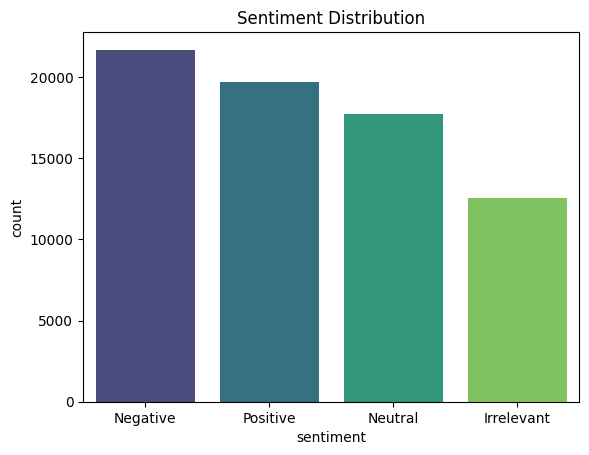

In [43]:
sns.countplot(x="sentiment", data=df, palette="viridis", order=df['sentiment'].value_counts().index)
plt.title("Sentiment Distribution")
plt.show()

In [44]:
df.columns

Index(['id', 'entity', 'sentiment', 'content'], dtype='object')

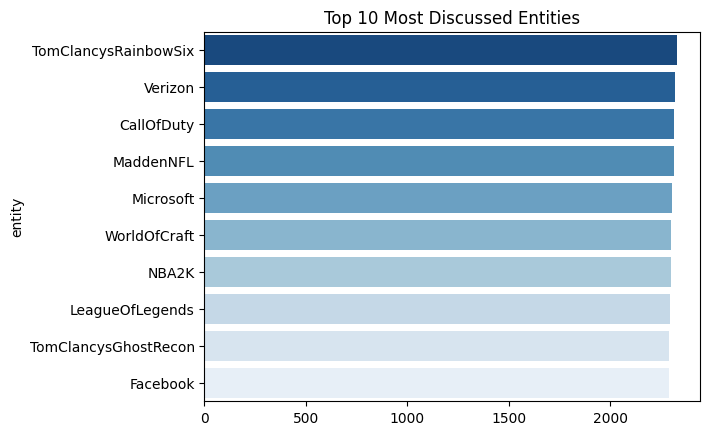

In [45]:
entity_counts = df["entity"].value_counts().head(10)
sns.barplot(y=entity_counts.index, x=entity_counts.values, palette="Blues_r")
plt.title("Top 10 Most Discussed Entities")
plt.show()

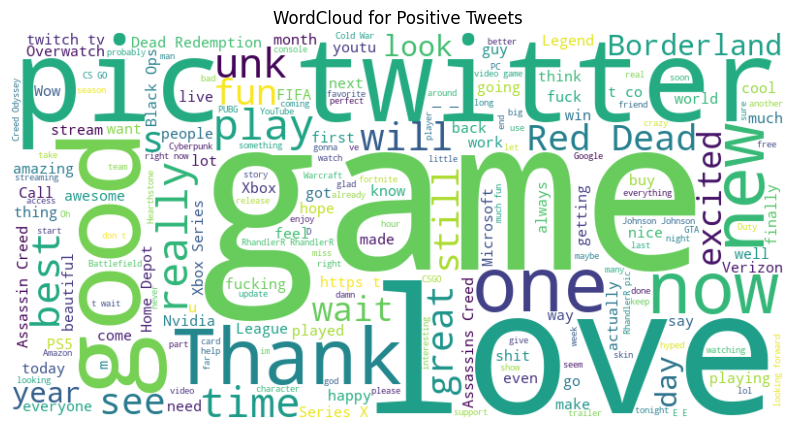

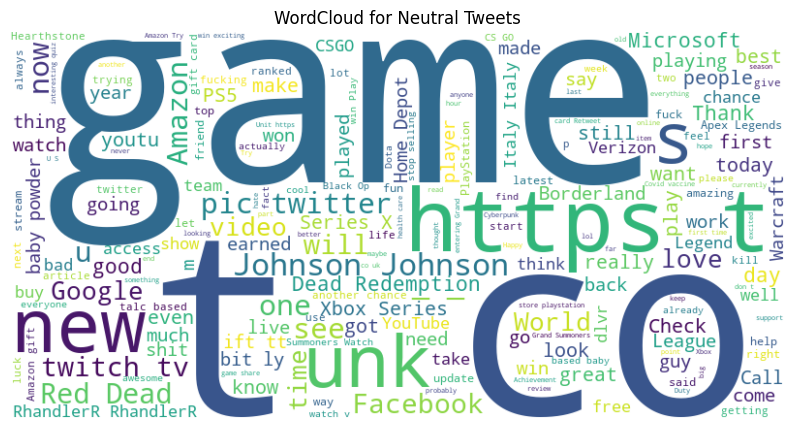

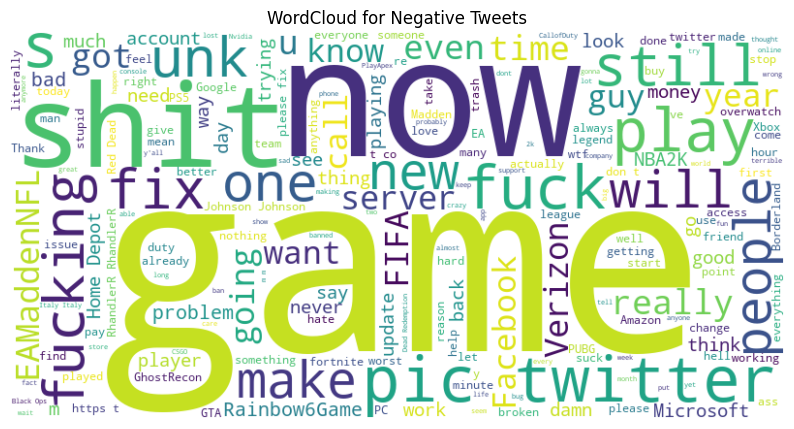

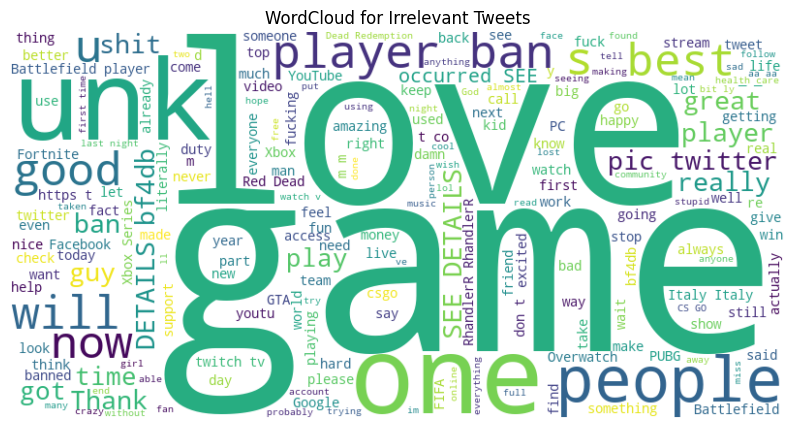

In [46]:
for sentiment in df["sentiment"].unique():
    text = " ".join(df[df["sentiment"] == sentiment]["content"].astype(str))
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for {sentiment} Tweets")
    plt.show()

In [47]:
df['text_length'] = df['content'].apply(lambda x: len(str(x).split()))


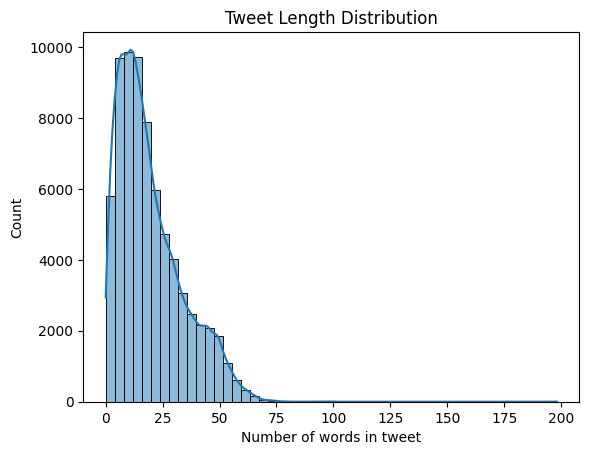

In [48]:
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Tweet Length Distribution")
plt.xlabel("Number of words in tweet")
plt.show()

In [49]:
for s in df['sentiment'].unique():
    print(f"\nExamples for Sentiment = {s}")
    print(df[df['sentiment']==s]['content'].head(3).to_list())



Examples for Sentiment = Positive
['im getting on borderlands and i will murder you all ,', 'I am coming to the borders and I will kill you all,', 'im getting on borderlands and i will kill you all,']

Examples for Sentiment = Neutral
['Rock-Hard La Varlope, RARE & POWERFUL, HANDSOME JACKPOT, Borderlands 3 (Xbox) dlvr.it/RMTrgF  ', 'Rock-Hard La Varlope, RARE & POWERFUL, HANDSOME JACKPOT, Borderlands 3 (Xbox) dlvr.it / RMTrgF', 'Rock-Hard La Varlope, RARE & POWERFUL, HANDSOME JACKPOT, Borderlands 3 (Xbox) dfr.it / RMTrgF']

Examples for Sentiment = Negative
['the biggest dissappoinment in my life came out a year ago fuck borderlands 3', 'The biggest disappointment of my life came a year ago.', 'the biggest dissappoinment in my life coming out a year ago fuck borderlands 3']

Examples for Sentiment = Irrelevant
['Appreciate the (sonic) concepts / praxis Valenzuela and Landa-Posas thread together in this talk: multimodal listening, soundwalks, borderlands frameworks, participatory actio

# **7. TEXT PREPROCESSING**
---
- Text preprocessing (lowercasing, stopword removal, lemmatization with SpaCy)

In [50]:

# Load English model for lemmatization
nlp = spacy.load("en_core_web_sm")


In [51]:

def clean_text(text):
    text = str(text).lower()                           # lowercase
    text = re.sub(r'http\S+', '', text)                # remove URLs
    text = re.sub(r'@\w+', '', text)                   # remove mentions
    text = re.sub(r'#\w+', '', text)                   # remove hashtags
    text = re.sub(r'[^a-z\s]', '', text)               # remove special characters, numbers, punctuation
    doc = nlp(text)                                    # NLP pipeline
    text = " ".join([token.lemma_ for token in doc if not token.is_stop])  # lemmatize & remove stopwords
    return text

# Apply cleaning
df['clean_content'] = df['content'].apply(clean_text)


In [52]:

# Check results
df[['content', 'clean_content']].head(10)


,content,clean_content
0,im getting on borderlands and i will murder yo...,m get borderland murder
1,I am coming to the borders and I will kill you...,come border kill
2,im getting on borderlands and i will kill you ...,m get borderland kill
3,im coming on borderlands and i will murder you...,m come borderland murder
4,im getting on borderlands 2 and i will murder ...,m get borderland murder
5,im getting into borderlands and i can murder y...,m get borderland murder
6,So I spent a few hours making something for fu...,spend hour make fun not know huge fan may...
7,So I spent a couple of hours doing something f...,spend couple hour fun not know m huge border...
8,So I spent a few hours doing something for fun...,spend hour fun not know m huge borderland fa...
9,So I spent a few hours making something for fu...,spend hour make fun not know huge rhandlerr...


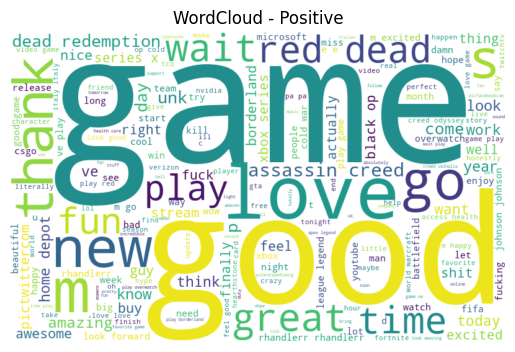

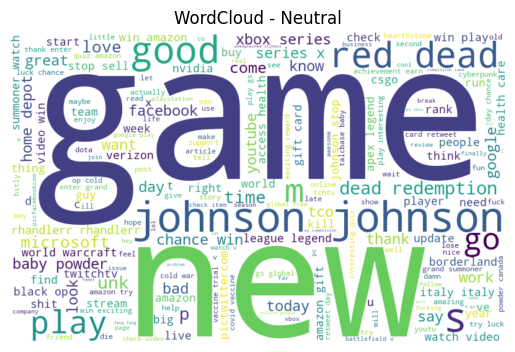

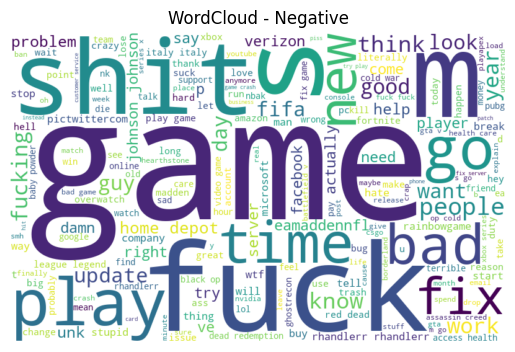

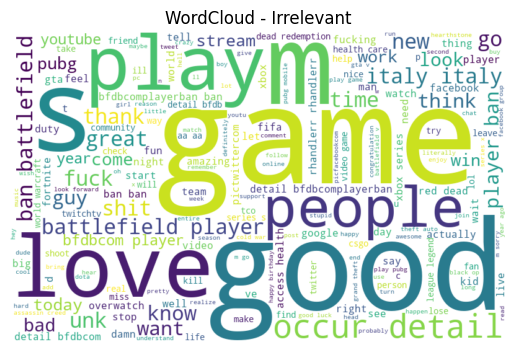

In [65]:
for sentiment in df["sentiment"].unique():
    text = " ".join(df[df["sentiment"]==sentiment]["clean_content"])
    wc = WordCloud(width=800, height=500, background_color="white").generate(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud - {sentiment}")
    plt.show()


# **8. FEATURE ENGINEERING**
---
- Convert text into numerical form using **TF-IDF Vectorization** 

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


In [55]:

# Features (X) = clean text, Target (y) = sentiment
X = df['clean_content']
y = df['sentiment']

# Convert text to TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)   # use top 5000 important words
X_tfidf = tfidf.fit_transform(X)


# **9. MODEL BUILDING**
- Train Logistic Regression ,Naive Bayes,SVM model  
- Train-Test Split  
---


In [56]:

# Split dataset into Train (80%) and Test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (57324, 5000)
Test size: (14331, 5000)


In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score


In [58]:

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC()
}


In [66]:

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)           # train model
    y_pred = model.predict(X_test)        # test model
    acc = accuracy_score(y_test, y_pred)  # accuracy
    print(f"\n🔹 Model:\n {name}")
    print("Accuracy:\n", round(acc, 4))
    print(classification_report(y_test, y_pred))



🔹 Model:
 Logistic Regression
Accuracy:
 0.6688
              precision    recall  f1-score   support

  Irrelevant       0.66      0.51      0.58      2507
    Negative       0.66      0.79      0.72      4340
     Neutral       0.67      0.60      0.63      3541
    Positive       0.67      0.70      0.69      3943

    accuracy                           0.67     14331
   macro avg       0.67      0.65      0.65     14331
weighted avg       0.67      0.67      0.66     14331


🔹 Model:
 Naive Bayes
Accuracy:
 0.6295
              precision    recall  f1-score   support

  Irrelevant       0.73      0.35      0.47      2507
    Negative       0.61      0.80      0.69      4340
     Neutral       0.66      0.52      0.58      3541
    Positive       0.61      0.71      0.66      3943

    accuracy                           0.63     14331
   macro avg       0.65      0.60      0.60     14331
weighted avg       0.64      0.63      0.62     14331


🔹 Model:
 SVM
Accuracy:
 0.6907
       

# **10. MODEL EVALUATION**
---
- Accuracy, Precision, Recall, F1-score  
- Confusion Matrix visualization  

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay


In [61]:

# SVM performed best
best_model = LinearSVC()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)


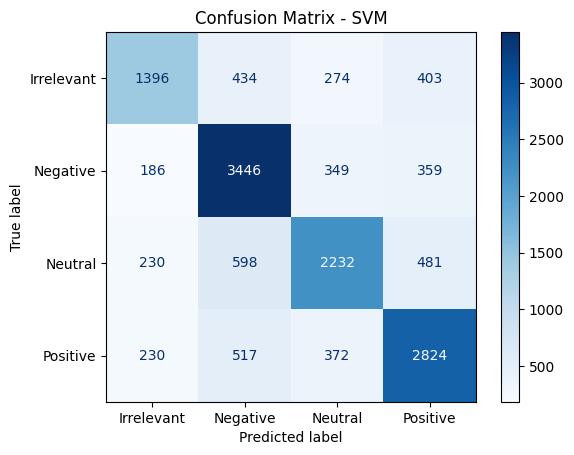

In [62]:

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - SVM")
plt.show()


In [63]:
# Store results in a dictionary
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = accuracy_score(y_test, y_pred)


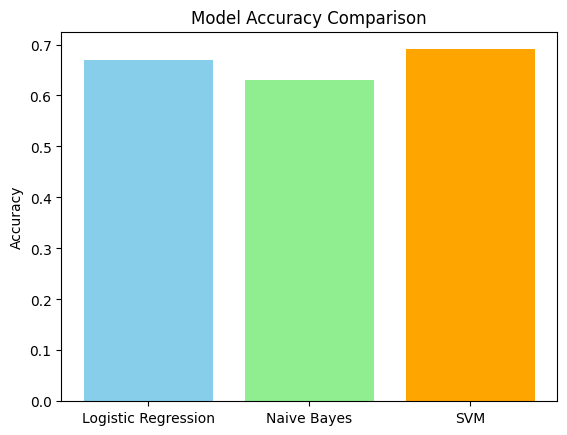

In [64]:

# Plot model comparison
plt.bar(results.keys(), results.values(), color=['skyblue','lightgreen','orange'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()


# **11. BUSINESS INSIGHTS**
---
- Positive tweets indicate **brand strengths** -can be used in promotions.
- Negative tweets highlight **customer pain points** -direct improvement areas.
- Neutral tweets provide **factual statements** -not actionable but useful for context.
- Irrelevant tweets can be **filtered out** to improve accuracy.  


## **12. CHALLENGES FACED**
---
- **Class imbalance** (e.g., more Neutral than Negative tweets).  
- **Text noise** (slangs, emojis, misspellings).  
- **Irrelevant category** creates overlap with Neutral.  
